# Continuous IFW method changes

#### Aims of a single function (+ parallelised)
- Calculate independent entropy of *significant feature*
- Calculate I (entropic) between that feature and those in sign_comp (significant interactions)
- Output information-theoretical omega
- When parallelised, recreate matrix as with bIFW

### Entropy calculation for toy genes

In [1]:
# import packages
import pandas as pd
import numpy as np
from functools import partial
from os.path import exists
import multiprocess
import scipy.sparse
import matplotlib.pyplot as plt
from p_tqdm import p_map
from scipy.stats import gaussian_kde
from scipy.integrate import quad
from sklearn.feature_selection import mutual_info_regression
import random
from scipy.integrate import dblquad

In [16]:
# create toy data
def toy_gene(numbers, values):
    gene = []
    for i, n in enumerate(numbers):
        for times in range(n):
            gene.append(values[i])
    return gene

toy_gene([4,1,8,3], [0.2,0,0.8,0])

[0.2, 0.2, 0.2, 0.2, 0, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0, 0, 0]

In [31]:
def toy_entropy(f1, alternative_entropy = False, evaluation_check = False):
    feature = f1    
    p0 = np.sum(feature == 0) / len(feature) if len(feature) > 0 else 0
    # Probability of zero
    non_zero_data = feature[feature != 0]

    # KDE for the non-zero part
    kde = gaussian_kde(non_zero_data)

    # Get the normalization factor by integrating KDE over the range of non-zero values
    #kde_normalisation_factor, _ = quad(lambda x: kde(x), 0, max(feature))

    # Combined PDF
    def combined_pdf(x):
        if x == 0:
            return p0 #/ kde_normalisation_factor
        else:
            return (1 - p0) * kde(x) #/ kde_normalisation_factor # sometimes we don't need it, but it helps

    integration_result, _ = quad(combined_pdf, 0, max(feature))

    # Check normalization (should be close to 1)
    normalisation_result = integration_result + p0  # Add p0 for the zero-inflated part
    if normalisation_result > 1 or normalisation_result < 0.95:
        print(f'\nNormalisation check unsuccessful. It should be close to 1 and it equals {normalisation_result}. This can lead to negative entropies. Proceeding with using summation instead of integration.')

    
    # Safe logarithm function
    def safe_log(x):
        return np.log(x) if x > 0 else 0

    # Combined PDF with log for entropy calculation
    def combined_pdf_log(x):
        fx = combined_pdf(x)
        return -fx * safe_log(fx)
    
    entropy_non_zero, _ = quad(combined_pdf_log, 0, max(feature))
    entropy_zero = -p0 * safe_log(p0)
    entropy = entropy_non_zero + entropy_zero

    if alternative_entropy == False:
        return entropy
    
    if alternative_entropy == True:
        # alternative entropy estimation: use sums
        x_values = np.arange(0, max(feature) + 1)
        pdf_log_values = [combined_pdf_log(x) for x in x_values]
        entropy_estimate = np.sum(pdf_log_values)
        return entropy, entropy_estimate

    if evaluation_check == True:
        print(f'\nNormalisation check, it should be close to 1: {normalisation_result}.')
        x_values = np.arange(0, max(feature) + 1)
        pdf_values = [combined_pdf(x) for x in x_values[0:np.random.randint(0,len(x_values), 10)]]
        log_values = [safe_log(fx) for fx in pdf_values[0:np.random.randint(0,len(x_values), 10)]]
        print("\n10 random x values:", x_values[0:np.random.randint(0,len(x_values), 10)])
        print("PDF values:", pdf_values[0:np.random.randint(0,len(x_values), 10)])
        print("Log values:", log_values[0:np.random.randint(0,len(x_values), 10)])


In [35]:
def simple_entropy(feature, kde_bandwith = None):
    # Probability of zero and data that is nonzero
    p0 = np.sum(feature == 0) / len(feature) if len(feature) > 0 else 0
    non_zero_data = feature[feature != 0]

    # zero  (H1)
    def safe_log(x):
        return np.log2(x) if x > 0 else 0
    entropy_zero = -p0 * safe_log(p0)

    # H2 (simplified)
    # KDE for the non-zero part
    kde = gaussian_kde(non_zero_data, bw_method=kde_bandwith)
    x = np.linspace(-0.5*max(feature), max(feature)*1.5, 10000)
    print(f"KDE normalisation check: {np.trapz(kde(x), x)}")
    # Simplified kde integration
    def h_integrand(fx):
        return fx * safe_log(fx)
    def kde_integrand(x):
        return kde(x) * safe_log(kde(x))
    
    kde_part_H2, _ = quad(kde_integrand, 0, max(feature))
    entropy_non_zero = -h_integrand(1-p0) - (1-p0) * kde_part_H2
    
    # Combined entropy
    entropy = entropy_non_zero + entropy_zero
    return entropy


In [36]:
toy_gene1 = toy_gene([4,1,8,3], [0.2,0,0.8,0])
simple_entropy(np.array(toy_gene1))

KDE normalisation check: 0.9911803929360335


0.9353219315102816

In [27]:
# entropy
f0 = np.array([0.9, 0.78, 0.69, 0.9, 0.8, 0, 0, 0, 0, 0])
f1 = np.array([0.9, 0.78, 0.69, 0.9, 0, 0, 0, 0, 0, 0])

f= [f0,f1]

H = []
for feat in f:
    entropy = simple_entropy(feat)
    H.append(entropy)
print(H)

KDE normalisation check: 0.999999999999467
KDE normalisation check: 0.9999999984885615
[0.45416599595886653, 0.6276190354205204]


In [28]:
# entropy
f0 = np.array([0.9, 0.98, 0.99, 0.9, 0.8, 0, 0, 0, 0, 0])
f1 = np.array([0.9, 0.98, 0.99, 0.9, 0, 0, 0, 0, 0, 0])

f= [f0,f1]

H = []
for feat in f:
    entropy = simple_entropy(feat)
    H.append(entropy)
print(H)

KDE normalisation check: 1.0
KDE normalisation check: 0.9999999999999998
[0.36218157782519667, 0.27158509172499845]


In [44]:
# entropy
f0 = np.array([0.99, 0.98, 0.99, 0.9, 0.8, 0, 0, 0, 0, 0])
f1 = np.array([0.99, 0.98, 0.99, 0.9, 0, 0, 0, 0, 0, 0])
f2 = np.array([0.99, 0.98, 0.99, 0, 0, 0, 0, 0, 0, 0])
f3 = np.array([0.99, 0.95, 0, 0, 0, 0, 0, 0, 0, 0])

f= [f0,f1, f2, f3]

H = []
for feat in f:
    entropy = simple_entropy(feat, kde_bandwith = 1.8)
    H.append(entropy)
print(H)

KDE normalisation check: 0.9997380902202165
KDE normalisation check: 0.9999999999144517
KDE normalisation check: 1.0000000000000002
KDE normalisation check: 0.9999999999999999
[0.7931942315573166, 0.5910109551643863, 0.054115083078609294, 0.42709458674684336]


In [47]:
# entropy
f0 = np.array([0.99, 0.98, 0.99, 0.9, 0.8, 0, 0, 0, 0, 0])
f1 = np.array([0.99, 0.98, 0.99, 0.9, 0, 0, 0, 0, 0, 0])
f2 = np.array([0.99, 0.98, 0.99, 0, 0, 0, 0, 0, 0, 0])
f3 = np.array([0.99, 0.95, 0, 0, 0, 0, 0, 0, 0, 0])

f= [f0,f1, f2, f3]

H = []
for feat in f:
    entropy = simple_entropy(feat)
    H.append(entropy)
print(H)

KDE normalisation check: 1.0000000000000002
KDE normalisation check: 1.0000000000000002
KDE normalisation check: 0.9999999999999998
KDE normalisation check: 1.0000000000000002
[0.503498667247195, 0.36914726909251605, -0.1611759293531077, 0.27222310552086953]


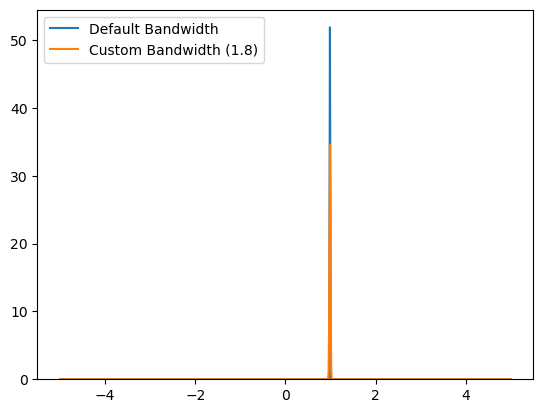

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Sample data
data =  np.array([0.99, 0.98, 0.99])

# KDE with different bandwidths
kde_default = gaussian_kde(data)
kde_custom = gaussian_kde(data, bw_method=1.8)

# Plot
x = np.linspace(-5, 5, 1000)
plt.plot(x, kde_default(x), label="Default Bandwidth")
plt.plot(x, kde_custom(x), label="Custom Bandwidth (1.8)")
plt.hist(data)
plt.legend()
plt.show()


to prevent negative entropies, check if a feature only has values close to 1, then increase the bandwidth until the entropy is bigger than 0?

in that case make sure that the comparison has the same bandwidth...?

In [2]:
# from chatgpt... can simply sum
from scipy.stats import gaussian_kde

# Function to calculate zero-inflated entropy
def zero_inflated_entropy(data, kde_bandwidth=0.1):
    """
    Calculate the zero-inflated entropy for a dataset.
    
    Parameters:
    - data: The input data (array-like).
    - kde_bandwidth: Bandwidth for KDE estimation.
    
    Returns:
    - entropy: The zero-inflated entropy.
    """
    # Count the number of zeros and nonzeros
    total_count = len(data)
    zero_count = np.sum(data == 0)
    nonzero_data = data[data > 0]

    # Calculate the zero probability (p0)
    p0 = zero_count / total_count

    # Contribution from the zero-probability term
    zero_entropy = 0 if p0 == 0 else -p0 * np.log2(p0)

    # KDE for the nonzero data
    if len(nonzero_data) > 0:
        kde = gaussian_kde(nonzero_data, bw_method=kde_bandwidth)
        # Create a fine grid for KDE evaluation
        grid = np.linspace(0, np.max(nonzero_data) * 1.1, 1000)
        kde_density = kde(grid) * (1 - p0)  # Scale density to (1 - p0)
        kde_density = kde_density / kde_density.sum()  # Normalize
        nonzero_entropy = -np.sum(kde_density * np.log2(kde_density + 1e-10))
    else:
        nonzero_entropy = 0

    # Total entropy
    total_entropy = zero_entropy + nonzero_entropy
    return total_entropy

# Define the vectors
vector3 = np.array([0.9, 0.98, 0, 0, 0, 0, 0, 0, 0, 0])
vector4 = np.array([0.9, 0.98, 0.99, 0.9, 0, 0, 0, 0, 0, 0])

# Calculate zero-inflated entropy for both vectors
entropy_vector3_zi = zero_inflated_entropy(vector3)
entropy_vector4_zi = zero_inflated_entropy(vector4)

print(entropy_vector3_zi, entropy_vector4_zi)


5.694837446662804 5.91271714027574


In [ ]:
# from chatgpt... can simply sum
from scipy.stats import gaussian_kde
import numpy as np
from scipy.stats import gaussian_kde
from scipy.integrate import quad

def zero_inflated_entropy_integration(data, kde_bandwidth=0.1):
    """
    Calculate the zero-inflated entropy using integration.
    
    Parameters:
    - data: The input data (array-like).
    - kde_bandwidth: Bandwidth for KDE estimation.
    
    Returns:
    - entropy: The zero-inflated entropy.
    """
    # Count the number of zeros and nonzeros
    total_count = len(data)
    zero_count = np.sum(data == 0)
    nonzero_data = data[data > 0]

    # Calculate the zero probability (p0)
    p0 = zero_count / total_count

    # Contribution from the zero-probability term
    zero_entropy = 0 if p0 == 0 else -p0 * np.log2(p0)

    # KDE for the nonzero data
    if len(nonzero_data) > 0:
        kde = gaussian_kde(nonzero_data, bw_method=kde_bandwidth)

        # Define the entropy function for integration
        def entropy_integrand(x):
            density = kde(x) * (1 - p0)  # Scale density to (1 - p0)
            return -density * np.log2(density + 1e-10)

        # Integration bounds (from 0 to slightly above max nonzero value)
        lower_bound = 0
        upper_bound = np.max(nonzero_data) * 1.1

        # Numerically integrate the entropy
        nonzero_entropy, _ = quad(entropy_integrand, lower_bound, upper_bound)
    else:
        nonzero_entropy = 0

    # Total entropy
    total_entropy = zero_entropy + nonzero_entropy
    return total_entropy

# Define the vectors
vector3 = np.array([0.9, 0.98, 0, 0, 0, 0, 0, 0, 0, 0])
vector4 = np.array([0.9, 0.98, 0.99, 0.9, 0, 0, 0, 0, 0, 0])

# Calculate zero-inflated entropy for both vectors
entropy_vector3_zi = zero_inflated_entropy_integration(vector3)
entropy_vector4_zi = zero_inflated_entropy_integration(vector4)

entropy_vector3_zi, entropy_vector4_zi



(-0.16180964503282597, -0.7773690503447938)

In [27]:
import timeit
execution_time = timeit.timeit(lambda: simple_entropy(np.array(toy_gene1)), number=1_000_000)
print(f"Average time per run: {execution_time / 1_000_000:.10f} seconds")

KeyboardInterrupt: 

In [ ]:
# another chatgpt answer using KernelDensity
import numpy as np
from sklearn.neighbors import KernelDensity

def kde_entropy(samples, bandwidth=0.1):
    kde = KernelDensity(bandwidth=bandwidth)
    kde.fit(samples[:, None])
    log_probs = kde.score_samples(samples[:, None])
    return -np.mean(log_probs)

def joint_entropy(x, y, bandwidth=0.1):
    xy = np.vstack([x, y]).T
    kde = KernelDensity(bandwidth=bandwidth)
    kde.fit(xy)
    log_probs = kde.score_samples(xy)
    return -np.mean(log_probs)

# Example data
x = np.array([0, 0, 0, 0.5, 0.8, 0.95])
y = np.array([0.1, 0, 0.2, 0.6, 0.8, 1.0])

# Calculate entropies
h_x = kde_entropy(x)
h_y = kde_entropy(y)
h_xy = joint_entropy(x, y)

# Mutual information
mutual_info = h_x + h_y - h_xy
print("Mutual Information:", mutual_info)


## Actually make up function

Correlation metric cIFW, with simple_entropy() function as ind_entropy()

In [3]:
def independent_entropy(feature, kde_bandwith = None):
    # Probability of zero and data that is nonzero
    p0 = np.sum(feature == 0) / len(feature) if len(feature) > 0 else 0
    non_zero_data = feature[feature != 0]

    # zero (H1)
    def safe_log(x):
        return np.log2(x) if x > 0 else 0
    entropy_zero = -p0 * safe_log(p0)

    # H2 (simplified)
    # KDE for the non-zero part
    kde = gaussian_kde(non_zero_data, bw_method=kde_bandwith)
    x = np.linspace(-0.5*max(feature), max(feature)*1.5, 10000)
    print(f"KDE normalisation check: {np.trapz(kde(x), x)}")
    # Simplified kde integration
    def h_integrand(fx):
        return fx * safe_log(fx)
    def kde_integrand(x):
        return kde(x) * safe_log(kde(x))
    
    kde_part_H2, _ = quad(kde_integrand, 0, max(feature))
    entropy_non_zero = -h_integrand(1-p0) - (1-p0) * kde_part_H2
    
    # Combined entropy
    entropy = entropy_non_zero + entropy_zero
    return entropy

f2 = np.array([0.99, 0.98, 0.99, 0, 0, 0, 0, 0, 0, 0])
entropy = independent_entropy(f2)

if entropy > 0:
    pass
else:
    it = 0
    kde_bandwith = 0
    while entropy < 0:
        it += 1
        kde_bandwith = kde_bandwith + 0.2
        print(f"Negative entropy detected. Recalculating with kde bandwidth {kde_bandwith}.")
        entropy = independent_entropy(f2, kde_bandwith = kde_bandwith)
        if it > 10:
            print("Could not find a suitable kde bandwidth.")
            break
        
print(entropy)


KDE normalisation check: 0.9999999999999998
Negative entropy detected. Recalculating with kde bandwidth 0.2.
KDE normalisation check: 0.9999999999999991
Negative entropy detected. Recalculating with kde bandwidth 0.4.
KDE normalisation check: 0.9999999999999994
Negative entropy detected. Recalculating with kde bandwidth 0.6000000000000001.
KDE normalisation check: 1.0000000000000004
Negative entropy detected. Recalculating with kde bandwidth 0.8.
KDE normalisation check: 0.9999999999999998
Negative entropy detected. Recalculating with kde bandwidth 1.0.
KDE normalisation check: 1.0
Negative entropy detected. Recalculating with kde bandwidth 1.2.
KDE normalisation check: 1.0
Negative entropy detected. Recalculating with kde bandwidth 1.4.
KDE normalisation check: 1.0
Negative entropy detected. Recalculating with kde bandwidth 1.5999999999999999.
KDE normalisation check: 0.9999999999999999
0.015317739150225218


In [3]:
from scipy.integrate import dblquad
f1 = np.array([0.97, 0.9, 0.99, 0, 0, 0, 0, 0, 0, 0])
f2 = np.array([0.99, 0.98, 0.99, 0, 0, 0, 0, 0, 0, 0])
p01 = np.mean(f1 == 0)
p02 = np.mean(f2 == 0)


In [9]:
def joint_entropy(f1, f2, p01, p02, kde_bandwidth=None):
    # obtain non-zero pairs
    joint_f = np.vstack([f1[f1>0], f2[f2>0]])
    kde = gaussian_kde(joint_f, bw_method=kde_bandwidth)
    # joint pdf
    adjusted_pdf = lambda x, y: kde([x, y]) * (1 - p01) * (1 - p02)
    def safe_log(x):
        return np.log2(x) if x > 0 else 0
    integrand = lambda x, y: -adjusted_pdf(x, y) * safe_log(adjusted_pdf(x, y))
    joint_entropy, _ = dblquad(integrand, 0, 1, lambda _: 0, lambda _: 1)
    return joint_entropy

entropy = joint_entropy(f1, f2, p01, p02,)

if entropy > 0:
    pass
else:
    it = 0
    kde_bandwith = 0
    while entropy < 0:
        it += 1
        kde_bandwith = kde_bandwith + 0.5
        print(f"Negative entropy detected. Recalculating with kde bandwidth {kde_bandwith}.")
        entropy = independent_entropy(f2, kde_bandwith = kde_bandwith)
        if it > 10:
            print("Could not find a suitable kde bandwidth.")
            break
    

KeyboardInterrupt: 

negative joint entropy?

In [5]:
# try summation
def zero_inflated_joint_entropy_summing(f1, f2, p01, p02, kde_bandwidth=None, grid_size=100):
    """Calculate joint entropy using summation."""
    x_vals = np.linspace(0, 1, grid_size)
    y_vals = np.linspace(0, 1, grid_size)
    xx, yy = np.meshgrid(x_vals, y_vals)
    grid_points = np.vstack([xx.ravel(), yy.ravel()])
    joint_f = np.vstack([f1[f1>0], f2[f2>0]])
    kde = gaussian_kde(joint_f, bw_method=kde_bandwidth)
    
    pdf_vals = kde(grid_points) * (1 - p01) * (1 - p02)  # Adjusted joint KDE
    def safe_log(x):
        return np.log2(x) if x > 0 else 0
    
    # Approximate joint entropy with summation
    dx = x_vals[1] - x_vals[0]
    dy = y_vals[1] - y_vals[0]
    pdf_vals[pdf_vals == 0] = 1e-10 # instead of safe_log
    joint_entropy = -np.sum(pdf_vals * np.log2(pdf_vals)) * (x_vals[1] - x_vals[0]) * (y_vals[1] - y_vals[0])
    return joint_entropy

zero_inflated_joint_entropy_summing(f1, f2, p01, p02)

-0.5528448068521383

In [30]:
# debug
grid_size = 100
kde_bandwith = None
x_vals = np.linspace(0, 1, grid_size)
y_vals = np.linspace(0, 1, grid_size)
xx, yy = np.meshgrid(x_vals, y_vals)
grid_points = np.vstack([xx.ravel(), yy.ravel()])
joint_f = np.vstack([f1[f1>0], f2[f2>0]])
kde = gaussian_kde(joint_f)

pdf_vals = kde(grid_points) * (1 - p01) * (1 - p02)  # Adjusted joint KDE
def safe_log(x):
    return np.log2(x) if x > 0 else 0

# Approximate joint entropy with summation
dx = x_vals[1] - x_vals[0]
dy = y_vals[1] - y_vals[0]
pdf_vals[pdf_vals < 1e-10] = 1e-10 # instead of safe_log
joint_entropy = -np.sum(pdf_vals * np.log2(pdf_vals)) * (x_vals[1] - x_vals[0]) * (y_vals[1] - y_vals[0])

In [16]:
np.sum(pdf_vals * np.log2(pdf_vals))

5418.4319497837805

In [17]:
(x_vals[1] - x_vals[0])

0.010101010101010102

In [18]:
(y_vals[1] - y_vals[0])

0.010101010101010102

In [20]:
pdf_vals.max()

134.19614785599336

In [21]:
# too high... make sure kde is normalised to 1...
#x = np.linspace(-0.5*max(feature), max(feature)*1.5, 10000)
#print(f"KDE normalisation check: {np.trapz(kde(x), x)}")

dx = x_vals[1] - x_vals[0]
dy = y_vals[1] - y_vals[0]
total_prob = np.sum(pdf_vals) * dx * dy
print("Total Probability:", total_prob)

Total Probability: 0.08572349142181133


In [26]:
# normalise?
pdf_vals /= pdf_vals.max()
pdf_vals

array([7.45177873e-13, 7.45177873e-13, 7.45177873e-13, ...,
       7.45177873e-13, 7.45177873e-13, 1.51268400e-09])

In [27]:
pdf_vals.max()

1.0

In [29]:
# too high... make sure kde is normalised to 1...
#x = np.linspace(-0.5*max(feature), max(feature)*1.5, 10000)
#print(f"KDE normalisation check: {np.trapz(kde(x), x)}")

dx = x_vals[1] - x_vals[0]
dy = y_vals[1] - y_vals[0]
total_prob = np.sum(pdf_vals) * dx * dy
print("Total Probability:", total_prob)

Total Probability: 0.000638792590670347


In [28]:
pdf_vals[pdf_vals < 1e-10] = 1e-10 # instead of safe_log
joint_entropy = -np.sum(pdf_vals * np.log2(pdf_vals)) * (x_vals[1] - x_vals[0]) * (y_vals[1] - y_vals[0])
joint_entropy

0.00039543889758638387

In [54]:
joint_f

array([[0.97, 0.9 , 0.99],
       [0.99, 0.98, 0.99]])

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

x2 = 

# KDE with different bandwidths
kde_default = gaussian_kde(joint_f)
kde_custom = gaussian_kde(joint_f, bw_method=1.8)

# Plot
x = np.linspace(-5, 5, 1000)
plt.plot(x, kde_default(x), label="Default Bandwidth")
plt.plot(x, kde_custom(x), label="Custom Bandwidth (1.8)")
plt.hist(data)
plt.legend()
plt.show()


ValueError: points have dimension 1, dataset has dimension 2

In [51]:
# debug
grid_size = 100
kde_bandwith = None
x_vals = np.linspace(0, 1, grid_size)
y_vals = np.linspace(0, 1, grid_size)
xx, yy = np.meshgrid(x_vals, y_vals)
grid_points = np.vstack([xx.ravel(), yy.ravel()])
joint_f = np.vstack([f1[f1>0], f2[f2>0]])
kde = gaussian_kde(joint_f, bw_method='scott')

pdf_vals = kde(grid_points) * (1 - p01) * (1 - p02)  # Adjusted joint KDE
def safe_log(x):
    return np.log2(x) if x > 0 else 0

# Approximate joint entropy with summation
dx = x_vals[1] - x_vals[0]
dy = y_vals[1] - y_vals[0]
pdf_vals[pdf_vals < 1e-10] = 1e-10 # instead of safe_log
#pdf_vals = np.clip(pdf_vals, None, 1.0)
#pdf_vals /= np.sum(pdf_vals) * dx * dy
joint_entropy = -np.sum(pdf_vals * np.log2(pdf_vals)) * (x_vals[1] - x_vals[0]) * (y_vals[1] - y_vals[0])

In [52]:
total_prob = np.sum(pdf_vals) * dx * dy
print("Total Probability:", total_prob)

Total Probability: 0.08572349142181133


In [53]:
joint_entropy

-0.5528448066303215

In [38]:
pdf_vals.max()

1.0

In [ ]:
# debug
grid_size = 100
kde_bandwith = None
x_vals = np.linspace(0, 1, grid_size)
y_vals = np.linspace(0, 1, grid_size)
xx, yy = np.meshgrid(x_vals, y_vals)
grid_points = np.vstack([xx.ravel(), yy.ravel()])
joint_f = np.vstack([f1[f1>0], f2[f2>0]])
kde = gaussian_kde(joint_f)

pdf_vals = kde(grid_points) * (1 - p01) * (1 - p02)  # Adjusted joint KDE
def safe_log(x):
    return np.log2(x) if x > 0 else 0

# Approximate joint entropy with summation
dx = x_vals[1] - x_vals[0]
dy = y_vals[1] - y_vals[0]
pdf_vals[pdf_vals < 1e-10] = 1e-10 # instead of safe_log
joint_entropy = -np.sum(pdf_vals * np.log2(pdf_vals)) * (x_vals[1] - x_vals[0]) * (y_vals[1] - y_vals[0])

In [6]:
import numpy as np
from scipy.stats import gaussian_kde

# Example joint data
x = np.array([0, 0, 0, 0.5, 0.8, 0.95])
y = np.array([0.1, 0, 0.2, 0.6, 0.8, 1.0])

# KDE and zero-inflation factors
p0_x = np.mean(x == 0)
p0_y = np.mean(y == 0)
non_zero_x = x[x > 0]
non_zero_y = y[y > 0]
kde_xy = gaussian_kde(np.vstack([non_zero_x, non_zero_y]))

# Grid for evaluation
grid_size = 100
x_vals = np.linspace(0, 1, grid_size)
y_vals = np.linspace(0, 1, grid_size)
xx, yy = np.meshgrid(x_vals, y_vals)
grid_points = np.vstack([xx.ravel(), yy.ravel()])

# Joint PDF with zero-inflation adjustment
pdf_vals = kde_xy(grid_points).reshape(xx.shape) * (1 - p0_x) * (1 - p0_y)

# Normalize the PDF
pdf_vals /= np.sum(pdf_vals) * (x_vals[1] - x_vals[0]) * (y_vals[1] - y_vals[0])

# Verify normalization
assert np.isclose(np.sum(pdf_vals) * (x_vals[1] - x_vals[0]) * (y_vals[1] - y_vals[0]), 1.0)

# Compute joint entropy
pdf_vals[pdf_vals == 0] = 1e-10  # Avoid log(0)
joint_entropy = -np.sum(pdf_vals * np.log(pdf_vals)) * (x_vals[1] - x_vals[0]) * (y_vals[1] - y_vals[0])

print("Joint Entropy:", joint_entropy)


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 3 and the array at index 1 has size 5

In [ ]:
#### Omega (Ω), the correlation metric, formerly Entropy Sort Score (ESS)
from scipy.integrate import dblquad
# The individual function to calculate the Omega scores for a given feature
def cIFW_correlation(feature_ind, sign_comp, normalised_matrix, extra_vectors = False, zero_info = True, extra_info = False):
    import numpy as np
    import scipy
    # get the list of significant features
    sign_list = [feat[1] for feat in sign_comp if feat[0] == feature_ind][0]
    MI_vector = []
    S_q_vector = []
    S_m_vector = []
    f1 = np.array(normalised_matrix.iloc[:,feature_ind])
    
    # entropy function
    def independent_entropy(feature, kde_bandwith = None):
        # Probability of zero and data that is nonzero
        p0 = np.sum(feature == 0) / len(feature) if len(feature) > 0 else 0
        non_zero_data = feature[feature != 0]

        # zero (H1)
        def safe_log(x):
            return np.log2(x) if x > 0 else 0
        entropy_zero = -p0 * safe_log(p0)

        # H2 (simplified)
        # KDE for the non-zero part
        kde = gaussian_kde(non_zero_data, bw_method=kde_bandwith)
        x = np.linspace(-0.5*max(feature), max(feature)*1.5, 10000) #range expanded for normalisation check
        print(f"KDE normalisation check: {np.trapz(kde(x), x)}")
        # Simplified kde integration
        def h_integrand(fx):
            return fx * safe_log(fx)
        def kde_integrand(x):
            return kde(x) * safe_log(kde(x))
        
        kde_part_H2, _ = quad(kde_integrand, 0, max(feature))
        entropy_non_zero = -h_integrand(1-p0) - (1-p0) * kde_part_H2 # simplified expression
        
        # Combined entropy
        entropy = entropy_non_zero + entropy_zero
        return entropy, p0
    
    H_f1, p01 = independent_entropy(f1)
    if H_f1 > 0:
        pass
    else: # in the case a negative entropy is obtained, widen KDE bandwidth
        it = 0
        kde_bandwith = 0
        while H_f1 < 0:
            it += 1
            kde_bandwith = kde_bandwith + 0.2
            #print(f"Negative entropy detected. Recalculating with kde bandwidth {kde_bandwith}.")
            H_f1 = independent_entropy(f1, kde_bandwith = kde_bandwith)
            if it > 10:
                #raise ValueError(f"Could not find a suitable kde bandwidth for gene {feature_ind}.")
                break
    
    for i in sign_list:
        #define feature 2
        f2 = np.array(normalised_matrix.iloc[:,i])
        
        H_f2, p02 = independent_entropy(f2, kde_bandwith = kde_bandwith) #use the same kde bandwidth as for f1
        if H_f2 > 0:
            pass
        else:
            raise ValueError(f"Could not find a suitable kde bandwidth for gene {i} that matches gene {feature_ind}.")
        
        ################################################
        
        # calculate the joint entropy
        
        n00 = 0
        n01 = 0
        n10 = 0
        n11 = 0
        
        if len(f1) != len(f2):
            print("Fixed feature and features from matrix must be of the same length (same n of cells).")
        else:
            c = len(f1)
            for (cell1, cell2) in zip(f1, f2):
                if cell1 == cell2:
                    if cell1 == 0:
                        n00 += 1
                    elif cell1 == 1:
                        n11 += 1
                        
                elif cell1 == 0:
                    if cell2 == 1:
                        n01 += 1
                        
                elif cell1 == 1:
                    if cell2 == 0:
                        n10 += 1
                        
        # check discretization
        ns = np.array([n00, n01, n10, n11])
        n_str = ["n00", "n01", "n10", "n11"]
        nsum = np.sum(ns)
        if nsum != c:
            print("Sum of state counts do not add up.")
            MI = np.nan
            S_q = np.nan
            S_m = np.nan
            
        #calculate c's - need to have at least one of each
        else:
            #wrt to f1
            c_m0 = n00 + n01
            c_m1 = n10 + n11
            #wrt to f2
            c_q0 = n00 + n10
            c_q1 = n01 + n11
            
            cs_MI = np.array([[c_m0, c_q0], [c_m0, c_q1],
                              [c_m1, c_q0], [c_m1, c_q1]])
            cs_S = np.array([[c_m0, c_m1],
                             [c_q0, c_q1]])
            
            MI_terms = []
            zeroterms = []
            for ind, n in enumerate(ns):
                if n != 0 & np.all(cs_MI[ind]) == False: #if n and both cs are nonzero, calculate
                    MI_term = (n/c * np.log2(c * n / (cs_MI[ind][0] * cs_MI[ind][1])))
                    MI_terms.append(MI_term)
                    
                else:
                    zeroterms.append(n_str[ind])
            MI = np.sum(MI_terms)
            
            # entropies separately
            S_m_terms = []
            S_q_terms = []
            
            for ind in range(len(cs_S)):
                S_m_terms.append(cs_S[0][ind]/c * np.log2(cs_S[0][ind]/c))
                S_q_terms.append(cs_S[1][ind]/c * np.log2(cs_S[1][ind]/c))
                
            S_m = np.sum(S_m_terms) * (-1)
            S_q = np.sum(S_q_terms) * (-1)

            if extra_info == True:     
                exclude = str()
                for t in zeroterms:
                    exclude += (t + ", ")
                print("Be aware that the counts " + exclude + "were 0. This affects the calculations.")
                
        MI_vector.append(MI)
        S_q_vector.append(S_q)
        S_m_vector.append(S_m)
    
    max_entropy = [max(Sm, Sq) for Sm, Sq in zip(S_m_vector, S_q_vector)]
    
    #now calculate omega
    if len(MI_vector) != len(max_entropy):
        raise ValueError("All vectors (MI, x_max, S_q and S_m) must have the same length")    

    omega_vector = np.array(MI_vector) / np.array(max_entropy)
    if extra_vectors == True:
        return [omega_vector, MI_vector, max_entropy]            
    else:
        return [omega_vector]
    
    
# The parallelised function to calculate the Omega for all features
def parallel_bIFW_correlation(binarised_data, sign_matrix, Use_Cores=-1):
    global binarised_dataset
    binarised_dataset = binarised_data
    print(f"Data loaded. Shape: {binarised_dataset.shape}. Proceeding to obtain indices for efficient ESS calculation.\n")
    nonzero = np.nonzero(sign_matrix.to_numpy())
    sign_comp = []
    for f in np.unique(nonzero[0]):
        #print(f"Gene {f} has a significant interaction with genes {nonzero[1][nonzero[0] == f]}")
        l = nonzero[1][nonzero[0] == f]
        sign_comp.append([f,l])
        #print(f"Gene {f} has a significant interaction with {len(l)} genes")
    Feature_Inds = [feat[0] for feat in sign_comp]
    print(f"Indices obtained. Proceeding with calculating ESSs in parallel.\n")
    
    ## Identify number of cores to use.
    Cores_Available = multiprocess.cpu_count()
    print("Cores Available: " + str(Cores_Available))
    if Use_Cores == -1:
        Use_Cores = Cores_Available - 1 # -1 Is an arbitrary buffer of idle cores that I set.
        if Use_Cores < 1:
            Use_Cores = 1
    print("Cores Used: " + str(Use_Cores))
    ## Perform calculations
    with np.errstate(divide='ignore',invalid='ignore'):
        allscores = p_map(partial(bIFW_correlation, sign_comp=sign_comp, normalised_matrix=binarised_dataset), Feature_Inds, num_cpus=Use_Cores)
    print(f"Calculations complete. Proceeding with matrix reconstruction.\n")
    omega = [row[0] for row in allscores]
    
    # Use allscores to build square matrix
    n = binarised_dataset.shape[1]
    indices = (nonzero[0], nonzero[1])
    values = [value for sublist in omega for value in sublist]
    # Initialize a zero matrix
    matrix = np.zeros((n, n), dtype=float)
    for row, col, value in zip(indices[0], indices[1], values):
        #print(f"Placing value {value} at position ({row}, {col})")  # Debug print
        matrix[row, col] = value
    
    print("Matrix construction complete. Saving to dataframe.")
    m = pd.DataFrame(matrix)
    return allscores, m

allscores, omega_matrix = parallel_bIFW_correlation(binarised_data=binarised_df, sign_matrix=chip_masked, Use_Cores=4)

Data loaded. Shape: (3000, 2546). Proceeding to obtain indices for efficient ESS calculation.

Indices obtained. Proceeding with calculating ESSs in parallel.

Cores Available: 8
Cores Used: 4


  0%|          | 0/2546 [00:00<?, ?it/s]

Calculations complete. Proceeding with matrix reconstruction.

Matrix construction complete. Saving to dataframe.
